In [1]:
# First, let's see what we can import
import sys
import decontx
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt



def create_test_data(n_genes=500, n_cells=200, n_empty=1000, contamination=0.1, seed=42):
    """Create simple synthetic data for testing."""
    np.random.seed(seed)

    # Create true expression for 5 cell types
    n_types = 5
    cells_per_type = n_cells // n_types
    true_counts = np.zeros((n_genes, n_cells))

    # Each cell type expresses different genes
    for cell_type in range(n_types):
        start_cell = cell_type * cells_per_type
        end_cell = min(start_cell + cells_per_type, n_cells)

        # High expression for marker genes
        marker_genes = range(cell_type * 20, (cell_type + 1) * 20)
        for cell in range(start_cell, end_cell):
            true_counts[list(marker_genes), cell] = np.random.poisson(20, 20)
            # Low background
            other_genes = list(set(range(n_genes)) - set(marker_genes))
            true_counts[other_genes, cell] = np.random.poisson(0.5, len(other_genes))

    # Create soup profile (average of all cells)
    soup_profile = np.mean(true_counts, axis=1)
    soup_profile = soup_profile / soup_profile.sum()

    # Add contamination
    observed = true_counts.copy()
    for cell in range(n_cells):
        cell_total = true_counts[:, cell].sum()
        contam_counts = np.random.poisson(soup_profile * cell_total * contamination)
        observed[:, cell] += contam_counts

    # Create empty droplets
    empty_counts = np.zeros((n_genes, n_empty))
    for i in range(n_empty):
        n_umis = np.random.poisson(10)  # Low UMI counts
        if n_umis > 0:
            empty_counts[:, i] = np.random.multinomial(n_umis, soup_profile)

    # Combine for raw matrix
    raw = np.hstack([empty_counts, observed])

    return {
        'raw': sp.csr_matrix(raw),
        'filtered': sp.csr_matrix(observed),
        'true': sp.csr_matrix(true_counts),
        'genes': [f"Gene_{i:04d}" for i in range(n_genes)],
        'cells': [f"Cell_{i:04d}" for i in range(n_cells)],
        'contamination': contamination,
        'cell_types': np.repeat(range(n_types), cells_per_type)[:n_cells]
    }

# Create test data
data = create_test_data(n_genes=300, n_cells=100, contamination=0.15, seed=42)
print(f"Created data: {data['raw'].shape[0]} genes, {data['raw'].shape[1]} droplets")
print(f"Filtered: {data['filtered'].shape[1]} cells")
print(f"True contamination: {data['contamination']:.1%}")

C:\Users\nruff\PycharmProjects\decontx-python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created data: 300 genes, 1100 droplets
Filtered: 100 cells
True contamination: 15.0%


In [2]:
# Clean imports now
from decontx import decontx, simulate_contamination
import anndata as adata_module
import pandas as pd
import numpy as np


print("✓ Successfully imported decontx functions")

✓ Successfully imported decontx functions


In [3]:
# Create AnnData object from your test data
adata = adata_module.AnnData(
    X=data['filtered'].T,  # AnnData expects cells x genes
    var=pd.DataFrame(index=data['genes']),
    obs=pd.DataFrame(index=data['cells'])
)

# Add cell type info
adata.obs['cell_type'] = data['cell_types']

print(f"Created AnnData: {adata.shape} (cells x genes)")
print(f"Cell types: {adata.obs['cell_type'].unique()}")
print(f"Data type: {type(adata.X)}")

Created AnnData: (100, 300) (cells x genes)
Cell types: [0 1 2 3 4]
Data type: <class 'scipy.sparse._csc.csc_matrix'>


In [4]:
# Very basic decontx test - expect this to break early!
try:
    print("Running basic decontx...")
    
    result = decontx(
        adata, 
        copy=True,
        verbose=True,
        max_iter=5,  # Very short for testing
        seed=42
    )
    
    print("🎉 It worked! (surprising)")
    print(f"Result shape: {result.shape}")
    
except Exception as e:
    print(f"💥 Expected error: {e}")
    
    # Show just the error type and message, not full traceback yet
    import traceback
    print(f"Error type: {type(e).__name__}")
    print("Last few lines of traceback:")
    tb_lines = traceback.format_exc().split('\n')
    for line in tb_lines[-6:]:
        if line.strip():
            print(f"  {line}")



Running basic decontx...
2025-09-05 09:44:26 --------------------------------------------------
2025-09-05 09:44:26 Starting DecontX
2025-09-05 09:44:26 --------------------------------------------------
2025-09-05 09:44:26 .. Generating UMAP and estimating cell types


C:\Users\nruff\PycharmProjects\decontx-python\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


2025-09-05 09:44:35 .... Generated 5 clusters using DBSCAN (eps=1.0)
2025-09-05 09:44:35 .... Using 5 cell clusters
2025-09-05 09:44:35 .. Processing 100 cells and 300 genes
2025-09-05 09:44:35 .... Estimating contamination
Iteration 0: LL = -279099.26, change = 0.243680
2025-09-05 09:44:46 ...... Mean contamination: 25.67%
2025-09-05 09:44:46 ...... Median contamination: 25.70%
2025-09-05 09:44:46 ...... Range: 24.25% - 26.75%
2025-09-05 09:44:46 ...... Cells >50% contaminated: 0
2025-09-05 09:44:46 ...... Converged in 2 likelihood evaluations
2025-09-05 09:44:46 .. Storing results
2025-09-05 09:44:46 .... Stored decontaminated counts in .layers['decontX_counts']
2025-09-05 09:44:46 .... Stored contamination estimates in .obs['decontX_contamination']
2025-09-05 09:44:46 --------------------------------------------------
2025-09-05 09:44:46 Completed DecontX
2025-09-05 09:44:46 --------------------------------------------------
🎉 It worked! (surprising)
Result shape: (100, 300)


In [5]:
# Check the returned result object, not the original adata
print("Results in returned object:")
print(f"Layers: {list(result.layers.keys())}")
print(f"Obs columns: {list(result.obs.columns)}")

# Check for contamination estimates
if 'decontX_contamination' in result.obs:
    print(f"Contamination range: {result.obs['decontX_contamination'].min():.1%} - {result.obs['decontX_contamination'].max():.1%}")
    print(f"Mean contamination: {result.obs['decontX_contamination'].mean():.1%}")

# Check for decontaminated counts
if 'decontX_counts' in result.layers:
    print(f"Decontaminated matrix shape: {result.layers['decontX_counts'].shape}")
    print(f"Original sum: {adata.X.sum():.0f}")
    print(f"Decontaminated sum: {result.layers['decontX_counts'].sum():.0f}")

Results in returned object:
Layers: ['decontX_counts']
Obs columns: ['cell_type', 'decontX_contamination', 'decontX_clusters']
Contamination range: 24.2% - 26.8%
Mean contamination: 25.7%
Decontaminated matrix shape: (100, 300)
Original sum: 62325
Decontaminated sum: 45437


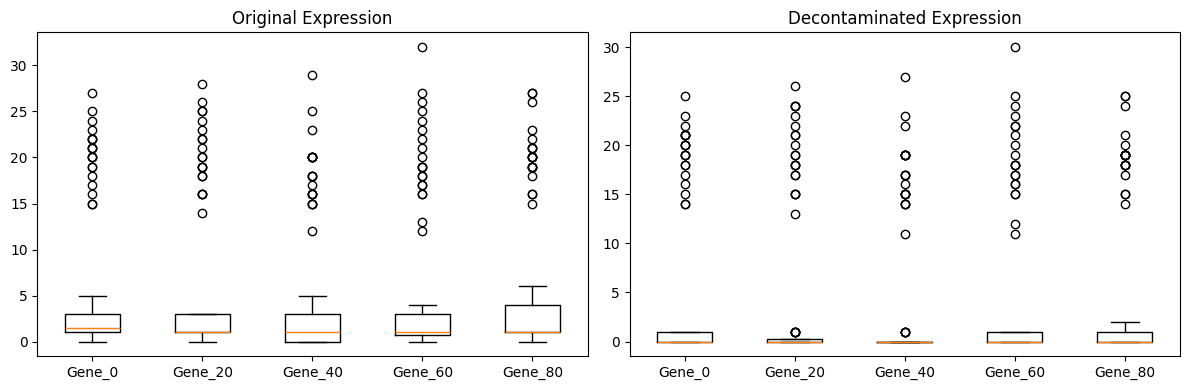

In [6]:
# Let's compare original vs decontaminated
import matplotlib.pyplot as plt

# Check a few marker genes
marker_genes = [f"Gene_{i:04d}" for i in [0, 20, 40, 60, 80]]  # One from each cell type
gene_idx = [result.var_names.get_loc(g) for g in marker_genes if g in result.var_names]

if gene_idx:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Original expression
    axes[0].boxplot([result.X[:, i].toarray().flatten() for i in gene_idx])
    axes[0].set_title("Original Expression")
    axes[0].set_xticklabels([f"Gene_{i*20}" for i in range(len(gene_idx))])
    
    # Decontaminated expression  
    axes[1].boxplot([result.layers['decontX_counts'][:, i] for i in gene_idx])
    axes[1].set_title("Decontaminated Expression")
    axes[1].set_xticklabels([f"Gene_{i*20}" for i in range(len(gene_idx))])
    
    plt.tight_layout()
    plt.show()

### PBMC3k testing - prepare with scanpy, then python vs R implementation

In [7]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import tarfile
import os
from pathlib import Path
from scipy.io import mmread

def load_10x_data_fixed(raw_tar_path, filtered_tar_path, extract_dir="./temp_10x/"):
    """
    Fixed loader for 10X Genomics data from tar.gz files.
    Properly handles matrix orientation - 10X matrices are stored as features x barcodes.
    """
    # Create extraction directory
    Path(extract_dir).mkdir(exist_ok=True)

    def find_matrix_files(base_dir):
        """Recursively find matrix.mtx, features.tsv/genes.tsv, barcodes.tsv"""
        matrix_file = None
        features_file = None
        barcodes_file = None
        for root, dirs, files in os.walk(base_dir):
            for file in files:
                file_path = os.path.join(root, file)
                if file == "matrix.mtx":
                    matrix_file = file_path
                elif file in ["features.tsv", "genes.tsv"]:
                    features_file = file_path
                elif file == "barcodes.tsv":
                    barcodes_file = file_path
        return matrix_file, features_file, barcodes_file

    def extract_and_load_matrix(tar_path, matrix_name):
        """Extract tar and load sparse matrix with correct orientation"""
        # Extract to subdirectory to avoid conflicts
        extract_subdir = os.path.join(extract_dir, matrix_name)
        Path(extract_subdir).mkdir(exist_ok=True)
        with tarfile.open(tar_path, 'r:gz') as tar:
            tar.extractall(extract_subdir)
        print(f"Loading {matrix_name} from {extract_subdir}")
        # Find matrix files recursively
        matrix_file, features_file, barcodes_file = find_matrix_files(extract_subdir)
        if not all([matrix_file, features_file, barcodes_file]):
            print(f"Missing files in {extract_subdir}:")
            print(f"  matrix.mtx: {matrix_file}")
            print(f"  features/genes.tsv: {features_file}")
            print(f"  barcodes.tsv: {barcodes_file}")
            raise FileNotFoundError("Required 10X files not found")
        # Load sparse matrix - 10X format is features x barcodes (genes x cells)
        matrix = mmread(matrix_file).tocsr()  # NO transpose - already correct orientation
        # Load gene names
        genes_df = pd.read_csv(features_file, sep='\t', header=None)
        if genes_df.shape[1] >= 2:
            gene_names = genes_df.iloc[:, 1].values  # Gene symbols (column 2)
        else:
            gene_names = genes_df.iloc[:, 0].values  # Gene IDs (column 1)
        # Load barcodes
        barcodes = pd.read_csv(barcodes_file, sep='\t', header=None).iloc[:, 0].values
        print(f"  Shape: {matrix.shape} (genes x cells)")
        print(f"  Genes: {len(gene_names)}")
        print(f"  Barcodes: {len(barcodes)}")
        # Validation - matrix should be genes x barcodes
        if matrix.shape[0] != len(gene_names):
            print(f"WARNING: Matrix rows ({matrix.shape[0]}) != gene names ({len(gene_names)})")
        if matrix.shape[1] != len(barcodes):
            print(f"WARNING: Matrix cols ({matrix.shape[1]}) != barcodes ({len(barcodes)})")
        return matrix, gene_names, barcodes

    # Load raw and filtered data
    print("Loading raw matrix...")
    raw_counts, raw_gene_names, raw_barcodes = extract_and_load_matrix(raw_tar_path, "raw")
    print("Loading filtered matrix...")
    filtered_counts, filt_gene_names, filt_barcodes = extract_and_load_matrix(filtered_tar_path, "filtered")

    # Verify gene names match
    if not np.array_equal(raw_gene_names, filt_gene_names):
        print("Warning: Gene names don't match between raw and filtered data")
        print(f"Raw genes: {len(raw_gene_names)}")
        print(f"Filtered genes: {len(filt_gene_names)}")
        # Try to find common genes
        common_genes = np.intersect1d(raw_gene_names, filt_gene_names)
        print(f"Common genes: {len(common_genes)}")
        if len(common_genes) > 0:
            # Subset to common genes
            raw_gene_idx = np.isin(raw_gene_names, common_genes)
            filt_gene_idx = np.isin(filt_gene_names, common_genes)
            raw_counts = raw_counts[raw_gene_idx, :]
            filtered_counts = filtered_counts[filt_gene_idx, :]
            raw_gene_names = raw_gene_names[raw_gene_idx]
            filt_gene_names = filt_gene_names[filt_gene_idx]
            print(f"Subsetted to {len(common_genes)} common genes")

    # Clean up
    import shutil
    shutil.rmtree(extract_dir)
    print(f"\nData loaded successfully:")
    print(f"Raw data: {raw_counts.shape} ({raw_counts.nnz:,} non-zero entries)")
    print(f"Filtered data: {filtered_counts.shape} ({filtered_counts.nnz:,} non-zero entries)")

    return raw_counts, filtered_counts, raw_gene_names, filt_gene_names, raw_barcodes, filt_barcodes

# Define the paths to your PBMC3k data files
raw_tar_path = "./pbmc3k_raw_gene_bc_matrices.tar.gz"
filtered_tar_path = "./pbmc3k_filtered_gene_bc_matrices.tar.gz"

# Load the data
raw_counts, filtered_counts, raw_genes, filt_genes, raw_barcodes, filt_barcodes = load_10x_data_fixed(raw_tar_path, filtered_tar_path)

Loading raw matrix...


C:\Users\nruff\AppData\Local\Temp\ipykernel_20432\4068571904.py:39: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_subdir)


Loading raw from ./temp_10x/raw
  Shape: (32738, 737280) (genes x cells)
  Genes: 32738
  Barcodes: 737280
Loading filtered matrix...
Loading filtered from ./temp_10x/filtered


C:\Users\nruff\AppData\Local\Temp\ipykernel_20432\4068571904.py:39: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_subdir)


  Shape: (32738, 2700) (genes x cells)
  Genes: 32738
  Barcodes: 2700

Data loaded successfully:
Raw data: (32738, 737280) (2,905,861 non-zero entries)
Filtered data: (32738, 2700) (2,286,884 non-zero entries)


In [8]:


import scanpy as sc

# Create an AnnData object for further processing
adata = sc.AnnData(filtered_counts.T)  # Transpose to get cells x genes
adata.var['gene_names'] = filt_genes
adata.obs['barcodes'] = filt_barcodes

# Perform basic preprocessing
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

# Perform PCA
sc.tl.pca(adata, svd_solver='arpack')

# Compute the neighborhood graph
sc.pp.neighbors(adata)

# Perform UMAP for visualization
sc.tl.umap(adata)

# Perform clustering
sc.tl.leiden(adata)

# Extract clusters for comparison
clusters = adata.obs['leiden'].astype('category').cat.codes.values

# Prepare data dictionary for comparison
data_for_comparison = {
    'raw': raw_counts,
    'filtered': filtered_counts,
    'genes': filt_genes,
    'clusters': clusters,
    'contamination': 0.1  # Example contamination level
}



C:\Users\nruff\PycharmProjects\decontx-python\.venv\Lib\site-packages\scanpy\preprocessing\_pca\__init__.py:385: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
C:\Users\nruff\AppData\Local\Temp\ipykernel_20432\1702426630.py:25: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


#### actual comparison here:

!! only operates on HVG rn as it took forever - I think we gotta optimze a bit here and there...

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


TESTING DECONTX CORE ALGORITHM WITH REAL PBMC DATA

Filtering:
  Original: 2700 cells, 32738 genes
  Filtered: 2700 cells, 16634 genes
  Removed 16104 zero-count genes
  Removed 0 zero-count cells

Data summary after filtering:
  Cells: 2700
  Genes: 16634
  Clusters: 9
  Cluster sizes: [586 526 405 374 348 246 151  52  12]
  UMIs per cell: mean=2367, median=2197

RUNNING PYTHON DECONTX

Default: delta=[10,10], estimate=True


C:\Users\nruff\PycharmProjects\decontx-python\decontx\model.py:302: RuntimeWarning: invalid value encountered in cast
  decontaminated = np.round(decontaminated).astype(int)


  Mean contamination: 45.7%
  Std contamination:  24.1%
  Range: 0.2% - 99.9%

Fixed: delta=[10,10], estimate=False
  Mean contamination: 45.7%
  Std contamination:  24.9%
  Range: 0.0% - 100.0%

Low contamination prior: delta=[90,10]
  Mean contamination: 16.2%
  Std contamination:  18.3%
  Range: 0.0% - 98.8%

RUNNING R DECONTX

    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    
Default: delta=[10,10], estimate=True
  Mean contamination: 73.8%
  Std contamination:  30.6%
  Range: 0.0% - 100.0%

Fixed: delta=[10,10], estimate=False
  Mean contamination: 72.0%
  Std contamination:  29.2%
  Range: 0.0% - 100.0%

Low contamination prior: delta=[90,10]
  Mean contamination: 58.3%
  Std contamination:  29.5%
  Range: 0.0% - 100.0%

DETAILED COMPARISON

Default: delta=[10,10], estimate=True:
  Python mean: 45.7%
  R mean:      73.8%
  Correlation: 0.

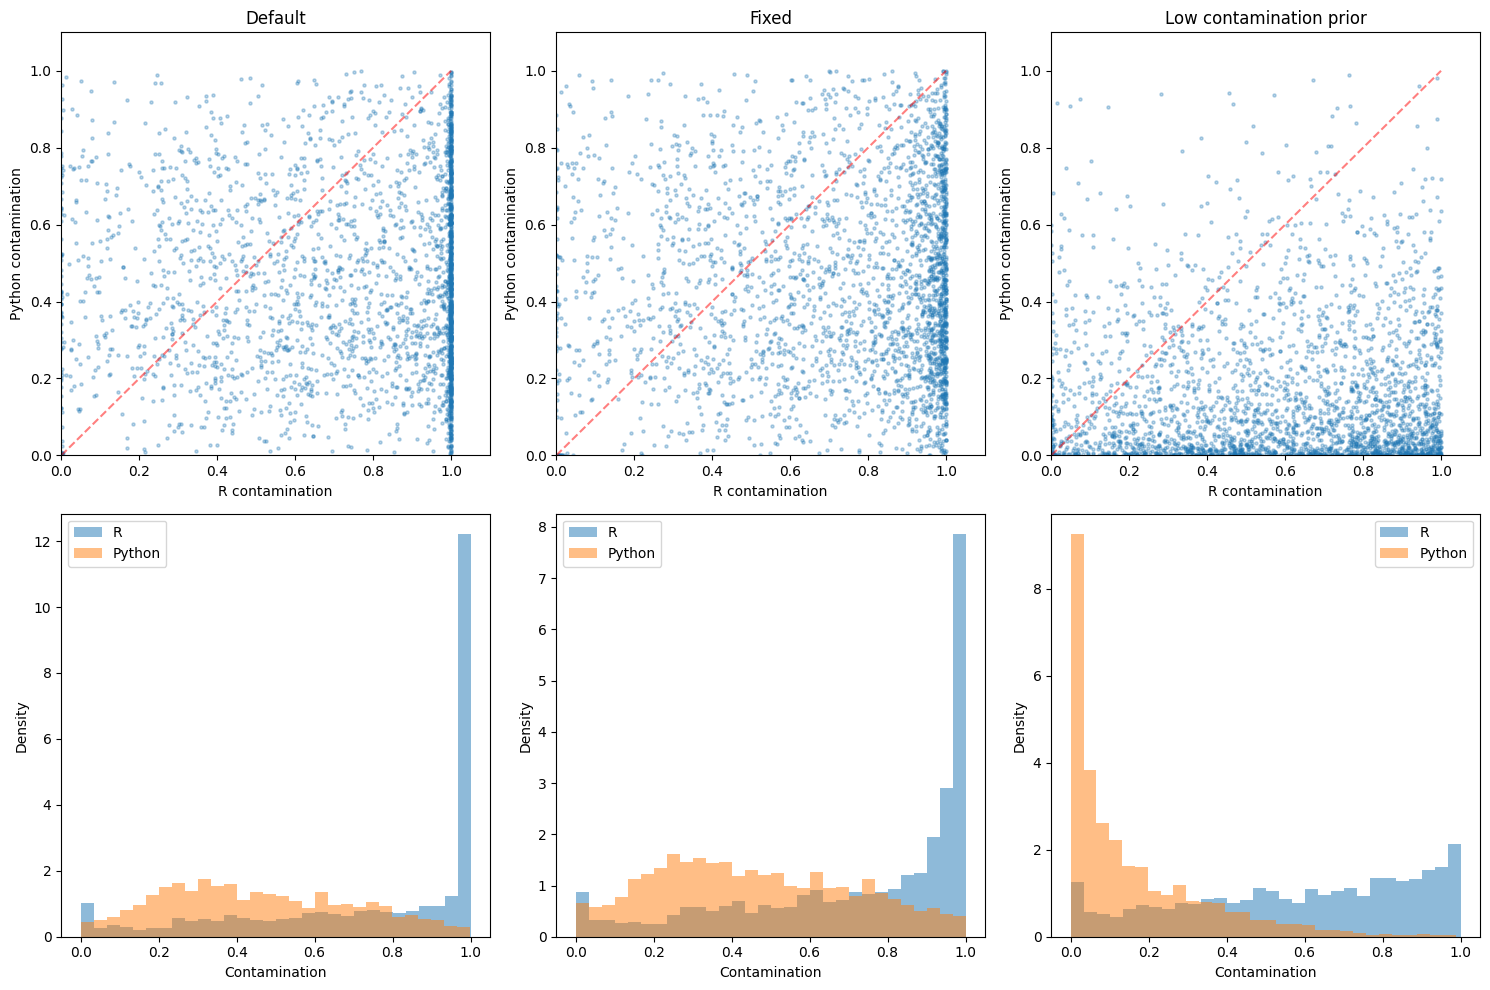


PER-CLUSTER CONTAMINATION (Default settings)

Cluster | Python Mean | R Mean | Difference
---------------------------------------------
    1   |    47.6%    |  78.1% |  -30.5%
    2   |    45.4%    |  65.2% |  -19.8%
    3   |    43.5%    |  65.4% |  -21.9%
    4   |    49.0%    |  79.2% |  -30.1%
    5   |    41.9%    |  79.9% |  -38.1%
    6   |    45.6%    |  79.7% |  -34.1%
    7   |    41.5%    |  75.1% |  -33.6%
    8   |    65.6%    |  82.1% |  -16.4%
    9   |     8.7%    |   0.1% |   +8.6%

CELLS WITH LARGEST DIFFERENCES

Cell | Cluster | Python | R      | Diff   | UMIs
-------------------------------------------------------
1761 |       8 |   0.2% |  99.7% |  99.5% | 10282
 426 |       8 |   0.6% | 100.0% |  99.4% | 10783
2187 |       4 |   0.5% |  99.7% |  99.2% | 1371
1184 |       8 |   0.9% | 100.0% |  99.1% | 6733
1855 |       4 |   1.1% | 100.0% |  98.9% | 1941


In [9]:
def test_decontx_core_with_real_data(adata, filtered_counts, filt_genes):
    """
    Test core decontX algorithm using real PBMC data and scanpy clusters.
    """
    import numpy as np
    import rpy2.robjects as ro
    from rpy2.robjects.conversion import localconverter
    from rpy2.robjects import numpy2ri, default_converter
    import matplotlib.pyplot as plt
    from scipy.sparse import issparse
    
    print("=" * 60)
    print("TESTING DECONTX CORE ALGORITHM WITH REAL PBMC DATA")
    print("=" * 60)
    
    # 1. Extract clusters from scanpy analysis
    clusters = adata.obs['leiden'].astype(int).values + 1  # Make 1-indexed for R
    
    # 2. Prepare count matrix
    if issparse(filtered_counts):
        counts_matrix = filtered_counts.T.toarray()  # cells x genes
    else:
        counts_matrix = filtered_counts.T  # cells x genes
    
    # ========== FILTER DATA FOR BOTH PYTHON AND R ==========
    # Remove genes with zero counts across all cells
    gene_sums = counts_matrix.sum(axis=0)
    valid_genes = gene_sums > 0
    counts_matrix_filtered = counts_matrix[:, valid_genes]
    
    # Remove cells with zero counts (shouldn't happen but check)
    cell_sums = counts_matrix_filtered.sum(axis=1)
    valid_cells = cell_sums > 0
    counts_matrix_filtered = counts_matrix_filtered[valid_cells, :]
    clusters_filtered = clusters[valid_cells]
    
    print(f"\nFiltering:")
    print(f"  Original: {counts_matrix.shape[0]} cells, {counts_matrix.shape[1]} genes")
    print(f"  Filtered: {counts_matrix_filtered.shape[0]} cells, {counts_matrix_filtered.shape[1]} genes")
    print(f"  Removed {counts_matrix.shape[1] - counts_matrix_filtered.shape[1]} zero-count genes")
    print(f"  Removed {counts_matrix.shape[0] - counts_matrix_filtered.shape[0]} zero-count cells")
    
    # Use filtered data for BOTH implementations
    counts_matrix = counts_matrix_filtered
    clusters = clusters_filtered
    
    n_clusters = len(np.unique(clusters))
    n_cells = len(clusters)
    n_genes = counts_matrix.shape[1]
    
    print(f"\nData summary after filtering:")
    print(f"  Cells: {n_cells}")
    print(f"  Genes: {n_genes}")
    print(f"  Clusters: {n_clusters}")
    print(f"  Cluster sizes: {np.bincount(clusters)[1:]}")
    
    # Basic stats
    total_umis = counts_matrix.sum(axis=1)
    print(f"  UMIs per cell: mean={total_umis.mean():.0f}, median={np.median(total_umis):.0f}")
    
    # 3. Run Python DecontX with PROVIDED clusters
    print("\n" + "="*40)
    print("RUNNING PYTHON DECONTX")
    print("="*40)
    
    from decontx.model import DecontXModel
    
    # Test with different delta priors
    delta_configs = [
        ([10, 10], True, "Default: delta=[10,10], estimate=True"),
        ([10, 10], False, "Fixed: delta=[10,10], estimate=False"),
        ([90, 10], False, "Low contamination prior: delta=[90,10]"),
    ]
    
    py_results = {}
    
    for delta, estimate, desc in delta_configs:
        print(f"\n{desc}")
        model = DecontXModel(
            max_iter=50,
            delta=delta,
            estimate_delta=estimate,
            convergence=0.001,
            seed=42,
            verbose=False
        )
        
        result = model.fit_transform(counts_matrix, clusters)
        contamination = result['contamination']
        
        print(f"  Mean contamination: {contamination.mean():.1%}")
        print(f"  Std contamination:  {contamination.std():.1%}")
        print(f"  Range: {contamination.min():.1%} - {contamination.max():.1%}")
        
        py_results[desc] = contamination
    
    # 4. Run R DecontX with same clusters
    print("\n" + "="*40)
    print("RUNNING R DECONTX")
    print("="*40)
    
    ro.r('library(decontX)')
    
    r_results = {}
    
    with localconverter(default_converter + numpy2ri.converter):
        # Convert data to R
        ro.globalenv['counts_r'] = ro.r.matrix(
            ro.FloatVector(counts_matrix.T.flatten()),
            nrow=n_genes,
            ncol=n_cells
        )
        ro.globalenv['z_r'] = ro.IntVector(clusters)
        
        for delta, estimate, desc in delta_configs:
            print(f"\n{desc}")
            
            delta_r = f"c({delta[0]}, {delta[1]})"
            estimate_r = "TRUE" if estimate else "FALSE"
            
            ro.r(f'''
            set.seed(42)
            result_r <- decontX(
                x = counts_r, 
                z = z_r,
                maxIter = 50,
                delta = {delta_r},
                estimateDelta = {estimate_r},
                convergence = 0.001,
                verbose = FALSE
            )
            contamination_r <- result_r$contamination
            ''')
            
            contamination = np.array(ro.r('contamination_r'))
            
            print(f"  Mean contamination: {contamination.mean():.1%}")
            print(f"  Std contamination:  {contamination.std():.1%}")
            print(f"  Range: {contamination.min():.1%} - {contamination.max():.1%}")
            
            r_results[desc] = contamination
    
    # 5. Detailed comparison
    print("\n" + "="*40)
    print("DETAILED COMPARISON")
    print("="*40)
    
    for desc in delta_configs:
        desc_str = desc[2]
        py_cont = py_results[desc_str]
        r_cont = r_results[desc_str]
        
        correlation = np.corrcoef(py_cont, r_cont)[0, 1]
        mae = np.mean(np.abs(py_cont - r_cont))
        
        print(f"\n{desc_str}:")
        print(f"  Python mean: {py_cont.mean():.1%}")
        print(f"  R mean:      {r_cont.mean():.1%}")
        print(f"  Correlation: {correlation:.3f}")
        print(f"  Mean Absolute Error: {mae:.1%}")
    
    # 6. Visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for idx, desc in enumerate(delta_configs):
        desc_str = desc[2]
        py_cont = py_results[desc_str]
        r_cont = r_results[desc_str]
        
        # Scatter plot
        ax = axes[0, idx]
        ax.scatter(r_cont, py_cont, alpha=0.3, s=5)
        ax.plot([0, 1], [0, 1], 'r--', alpha=0.5)
        ax.set_xlabel('R contamination')
        ax.set_ylabel('Python contamination')
        ax.set_title(f'{desc_str.split(":")[0]}')
        ax.set_xlim([0, max(r_cont.max(), py_cont.max()) * 1.1])
        ax.set_ylim([0, max(r_cont.max(), py_cont.max()) * 1.1])
        
        # Histogram
        ax = axes[1, idx]
        ax.hist(r_cont, bins=30, alpha=0.5, label='R', density=True)
        ax.hist(py_cont, bins=30, alpha=0.5, label='Python', density=True)
        ax.set_xlabel('Contamination')
        ax.set_ylabel('Density')
        ax.legend()
    
    plt.tight_layout()
    plt.savefig('decontx_comparison_real_data.png', dpi=150)
    plt.show()
    
    # 7. Per-cluster analysis
    print("\n" + "="*40)
    print("PER-CLUSTER CONTAMINATION (Default settings)")
    print("="*40)
    
    py_default = py_results[delta_configs[0][2]]
    r_default = r_results[delta_configs[0][2]]
    
    print("\nCluster | Python Mean | R Mean | Difference")
    print("-" * 45)
    
    for cluster_id in np.unique(clusters):
        mask = clusters == cluster_id
        py_mean = py_default[mask].mean()
        r_mean = r_default[mask].mean()
        diff = py_mean - r_mean
        print(f"   {cluster_id:2d}   |   {py_mean:6.1%}    | {r_mean:6.1%} |  {diff:+6.1%}")
    
    # 8. Check cells with extreme differences
    print("\n" + "="*40)
    print("CELLS WITH LARGEST DIFFERENCES")
    print("="*40)
    
    diffs = np.abs(py_default - r_default)
    top_diff_idx = np.argsort(diffs)[-10:][::-1]
    
    print("\nCell | Cluster | Python | R      | Diff   | UMIs")
    print("-" * 55)
    for idx in top_diff_idx[:5]:
        print(f"{idx:4d} | {clusters[idx]:7d} | {py_default[idx]:6.1%} | {r_default[idx]:6.1%} | "
              f"{diffs[idx]:6.1%} | {total_umis[idx]:4.0f}")
    
    return py_results, r_results, clusters

# Run the test with your data
py_results, r_results, clusters = test_decontx_core_with_real_data(
    adata, 
    filtered_counts, 
    filt_genes
)